##  CNN做MNIST分类
refer: http://wiki.jikexueyuan.com/project/tensorflow-zh/tutorials/mnist_pros.html<br/>
@author: huangyongye
<br/>@date: 2017-02-24
<br/><br/>在测试的过程中出现了ResourceExhaustedError ，就是资源耗尽了！！！
<br/>之前在keras中用同样的网络和同样的数据集来做这个例子的时候。keras占用了 5647M 的显存（训练过程中设了 validation_split = 0.2， 也就是1.2万张图）。

但是我用 tensorflow 自己写的 batch=50 来测试发现呀只有529的占用显存！！！只是在最后做测试的时候因为是对10000多张图片一次性做预测才占用了 8721M 的显存<font color="red">这里的测试集是 1 万张</font>。如果把预测时候的 batch 也设得比较小的话，那么整个网络只需要很小的显存了。

In [1]:
import numpy as np
import tensorflow as tf

# 设置按需使用GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

## 1.导入数据，用 tensorflow 导入

In [2]:
# 用tensorflow 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# 看看咱们样本的数量
print mnist.test.labels.shape
print mnist.train.labels.shape

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(10000, 10)
(55000, 10)


## 2. 构建网络

In [3]:
# 权值初始化
def weight_variable(shape):
    # 用正态分布来初始化权值
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # 本例中用relu激活函数，所以用一个很小的正偏置较好
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 定义卷积层
def conv2d(x, W):
    # 默认 strides[0]=strides[3]=1, strides[1]为x方向步长，strides[2]为y方向步长
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# pooling 层
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


X_ = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# 把X转为卷积所需要的形式
X = tf.reshape(X_, [-1, 28, 28, 1])
# 第一层卷积：5×5×1卷积核32个 [5，5，1，32]
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)

# 第一个pooling 层
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积：5×5×32卷积核64个 [5，5，32，64]
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 第二个pooling 层,输出[None, 7, 7, 64] ? 
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# fc1
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout: 输出的维度和h_fc1一样，只是随机部分值被值为零
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

看看各层输出 tensor 的维度

In [4]:
print(X_)
print(y_)
print(h_conv1)
print(h_pool1)
print(h_conv2)
print(h_pool2)
print(h_fc1)
print(y_conv)

Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)
Tensor("Softmax:0", shape=(?, 10), dtype=float32)


## 3.训练和评估

<b> 在测试的时候不使用 mini_batch， 那么测试的时候会占用较多的GPU（4497M），这在 notebook 交互式编程中是不推荐的。

In [5]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())
for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            X_:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, train_accuracy)
    train_step.run(feed_dict={X_: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={
    X_: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})

step 0, training accuracy 0.04
step 1000, training accuracy 1
step 2000, training accuracy 1
step 3000, training accuracy 0.98
step 4000, training accuracy 0.98
step 5000, training accuracy 0.98
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
test accuracy 0.9908


<b> 下面改成了 test 也用 mini_batch 的形式， 显存只用了 529M,所以还是很成功的。

In [6]:
# 题外话：在做这个例子的过程中遇到过：资源耗尽的错误，为什么？
# -> 因为之前每次做 train_acc  的时候用了全部的 55000 张图，显存爆了.

# 1.损失函数：cross_entropy
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
# 2.优化函数：AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
#　预测值中最大值（１）即分类结果，是否等于原始标签中的（１）的位置。argmax()取最大值所在的下标
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.arg_max(y_, 1))  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# 如果一次性来做测试的话，可能占用的显存会比较多，所以测试的时候也可以设置较小的batch来看准确率
test_acc_sum = tf.Variable(0.0)
batch_acc = tf.placeholder(tf.float32)
new_test_acc_sum = tf.add(test_acc_sum, batch_acc)
update = tf.assign(test_acc_sum, new_test_acc_sum)

# 定义了变量必须要初始化，或者下面形式
sess.run(tf.global_variables_initializer())
# 或者某个变量单独初始化 如：
# x.initializer.run()

# 训练
for i in range(5000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=50)
    if i % 500 == 0:
        train_accuracy = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0})
        print "step %d, training acc %g" % (i, train_accuracy)
    train_step.run(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 0.5})  

# 全部训练完了再做测试，batch_size=100
for i in range(100): 
    X_batch, y_batch = mnist.test.next_batch(batch_size=100)
    test_acc = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0})
    update.eval(feed_dict={batch_acc: test_acc})
    if (i+1) % 20 == 0:
        print "testing step %d, test_acc_sum %g" % (i+1, test_acc_sum.eval())
print " test_accuracy %g" % (test_acc_sum.eval() / 100.0)

step 0, training acc 0.04
step 500, training acc 0.9
step 1000, training acc 0.96
step 1500, training acc 1
step 2000, training acc 0.96
step 2500, training acc 1
step 3000, training acc 0.98
step 3500, training acc 0.96
step 4000, training acc 0.98
step 4500, training acc 0.98
testing step 20, test_acc_sum 19.74
testing step 40, test_acc_sum 39.47
testing step 60, test_acc_sum 59.14
testing step 80, test_acc_sum 78.83
testing step 100, test_acc_sum 98.61
 test_accuracy 0.9861


## 4. 查看网络中间结果

<b> 在学习 CNN 的过程中，老是看到他们用图片的形式展示了中间层卷积的输出。好吧，这下我必须得自己实现以下看看呀！！！</b>
<br/> 关于 python 图片操作主要有 matplotlib 和 PIL 两个库（refer to: http://www.cnblogs.com/yinxiangnan-charles/p/5928689.html）。
<br/>我们使用 matplotlib 来完成这个任务。

### 4.1 图像操作基础

In [7]:
# 我们先来看看数据是什么样的
img1 = mnist.train.images[1]
label1 = mnist.train.labels[1]
print label1  
print 'img_data shape =', img1.shape  # 我们需要把它转为 28 * 28 的矩阵
img1.shape = [28, 28]

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
img_data shape = (784,)


(28, 28)


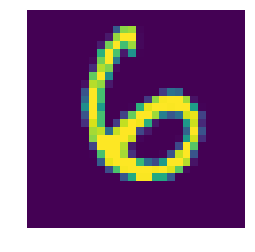

In [8]:
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg  # 用于读取图片，这里用不上

print img1.shape
plt.imshow(img1)
plt.axis('off') # 不显示坐标轴
plt.show()   

好吧，是显示了图片，但是结果是热度图像。我们想显示的是灰度图像。

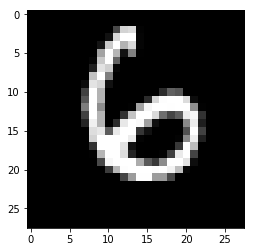

In [9]:
# 我们可以通过设置 cmap 参数来显示灰度图
plt.imshow(img1, cmap='gray') # 'hot' 是热度图
plt.show()

我们想看 Conv1 层的32个卷积滤波后的结果，显示在同一张图上。 python 中也有 plt.subplot(121) 这样的方法来帮我们解决这个问题。如下：先看两个试试

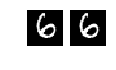

In [10]:
plt.subplot(4,8,1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(4,8,2)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

### 4.2 显示网络中间结果

好了，有了前面的图像操作基础，我们就该试试吧！！！

In [11]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = img1.reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10])
# 我们要看 Conv1 的结果，即 h_conv1
result = h_conv1.eval(feed_dict={X_: X_img, y_: y_img, keep_prob: 1.0})
print result.shape
print type(result)

(1, 28, 28, 32)
<type 'numpy.ndarray'>


好的，我们成功的计算得到了 h_conv1，那么赶紧 imshow() 看看吧！！！

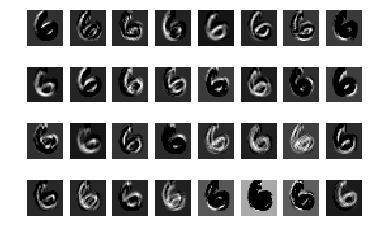

In [12]:
for _ in xrange(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

哈哈，成功啦！从上面的结果中，我们可以看到不同的滤波器（卷积核）学习到了不同的特征。比如第一行中，第一个滤波器学习到了边缘信息，第5个卷积核，则学习到了骨干的信息。感觉好有趣，不由自主的想对另一个数字看看。

In [13]:
# 输出前10个看看，我选择数字 8 来试试
print mnist.train.labels[:10]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


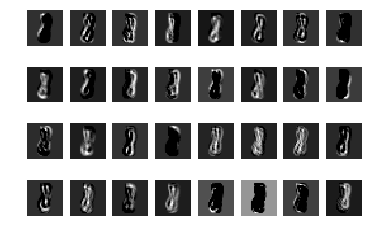

In [14]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = mnist.train.images[0].reshape([-1, 784])
result = h_conv1.eval(feed_dict={X_: X_img, keep_prob: 1.0})

for _ in xrange(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

第一个核还是主要学习到了边缘特征，第五个核还是学到了骨干特征（当然在某种程度上）。好吧，本次就到这啦！